# _(Diesmann, et, al., 1999)_ Synfire Chains

Implementation of the paper:

- Diesmann, Markus, Marc-Oliver Gewaltig, and Ad Aertsen. "Stable propagation of synchronous spiking in cortical neural networks." Nature 402.6761 (1999): 529-533.

Author:

- Chaoming Wang (chao.brain@qq.com)

In [1]:
import brainpy as bp

In [2]:
duration = 100.  # ms

# Neuron model parameters
Vr = -70.  # mV
Vt = -55.  # mV
tau_m = 10.  # ms
tau_ref = 1.  # ms
tau_psp = 0.325  # ms
weight = 4.86  # mV
noise = 39.24  # mV

# Neuron groups
n_groups = 10
group_size = 100
spike_sigma = 1.

# Synapse parameter
delay = 5.0  # ms

In [3]:
# neuron model
# ------------


class Groups(bp.NeuGroup):
  def __init__(self, size, **kwargs):
    super(Groups, self).__init__(size, **kwargs)

    self.V = bp.math.Variable(Vr + bp.math.random.random(self.num) * (Vt - Vr))
    self.x = bp.math.Variable(bp.math.zeros(self.num))
    self.y = bp.math.Variable(bp.math.zeros(self.num))
    self.spike = bp.math.Variable(bp.math.zeros(self.num))
    self.not_ref = bp.math.Variable(bp.math.ones(self.num))
    self.t_last_spike = bp.math.Variable(bp.math.ones(self.num) * -1e7)

  @bp.odeint
  def int_V(self, V, t, x):
    return (-(V - Vr) + x) / tau_m

  @bp.odeint
  def int_x(self, x, t, y):
    return (-x + y) / tau_psp

  @staticmethod
  @bp.sdeint(g=lambda y, t: noise)
  def int_y(y, t):
    df = -y / tau_psp + 25.27
    return df

  def update(self, _t, _dt):
    self.x[:] = self.int_x(self.x, _t, self.y)
    self.y[:] = self.int_y(self.y, _t)

    for i in range(self.num):
      self.spike[i] = False
      self.not_ref[i] = 0.
      if _t - self.t_last_spike[i] >= tau_ref:
        V = self.int_V(self.V[i], _t, self.x[i])
        if V > Vt:
          self.spike[i] = True
          self.t_last_spike[i] = _t
          self.V[i] = Vr
        else:
          self.V[i] = V
          self.not_ref[i] = 1.

In [4]:
# synaptic  model
# ---------------

class SynBetweenGroups(bp.TwoEndConn):
  def __init__(self, group, ext_group, **kwargs):
    super(SynBetweenGroups, self).__init__(group, group, **kwargs)

    self.group = group
    self.ext = ext_group

    # connections
    self.mat1 = bp.math.ones((ext_group.num, group_size))
    self.mat2 = bp.math.ones((group_size, group_size))

    # variables
    self.g = self.register_constant_delay('g', size=group.num, delay=delay)

  def update(self, _t, _dt):
    # synapse model between external and group 1
    g = bp.math.zeros(self.group.num)
    g[:group_size] = weight * bp.math.dot(self.ext.spike, self.mat1)
    # feed-forward connection
    for i in range(1, n_groups):
      s1 = (i - 1) * group_size
      s2 = i * group_size
      s3 = (i + 1) * group_size
      g[s2: s3] = weight * bp.math.dot(self.group.spike[s1: s2], self.mat2)
    # delay push
    self.g.push(g)
    # delay pull
    self.group.y += self.g.pull()

In [5]:
# Spike time group
# ----------------

class SpikeTimeInput(bp.NeuGroup):
  target_backend = 'numpy'

  def __init__(self, size, times, indices, need_sort=1., **kwargs):
    super(SpikeTimeInput, self).__init__(size=size, **kwargs)

    if len(indices) != len(times):
      raise ValueError(f'The length of "indices" and "times" must be the same. '
                       f'However, we got {len(indices)} != {len(times)}.')

    # data about times and indices
    self.idx = bp.math.Variable([0])
    self.times = bp.math.asarray(times, dtype=bp.math.float_)
    self.indices = bp.math.asarray(indices, dtype=bp.math.int_)
    self.num_times = len(times)
    if need_sort:
      sort_idx = bp.math.argsort(times)
      self.indices = self.indices[sort_idx]
    self.spike = bp.math.Variable(bp.math.zeros(self.num, dtype=bool))

  def update(self, _t, _dt):
    self.spike[:] = False
    while self.idx[0] < self.num_times and _t >= self.times[self.idx[0]]:
      idx = self.indices[self.idx[0]]
      self.spike[idx] = True
      self.idx[:] += 1

In [6]:
# network running
# ---------------

def run_network(spike_num=48):
  times = bp.math.random.randn(spike_num) * spike_sigma + 20
  ext_group = SpikeTimeInput(spike_num, times=times, indices=bp.math.arange(spike_num))
  group = Groups(size=n_groups * group_size, monitors=['spike'])
  syn_conn = SynBetweenGroups(group, ext_group)

  net = bp.Network(group, ext_group, syn_conn)
  net.run(duration, report=0.2)

  bp.visualize.raster_plot(group.mon.ts, group.mon.spike, xlim=(0, duration), show=True)

When external spike num is 51, there exists "synfire chain".

Compilation used 0.0025 s.
Start running ...
Run 20.0% used 1.116 s.
Run 40.0% used 2.220 s.
Run 60.0% used 3.651 s.
Run 80.0% used 4.745 s.
Run 100.0% used 5.844 s.
Simulation is done in 5.845 s.



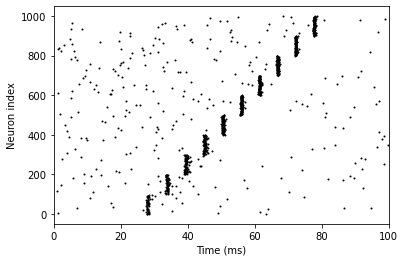

In [7]:
run_network(spike_num=51)

When external spike num is 44, the synchronous excitation disperses and eventually dies out.

Compilation used 0.0032 s.
Start running ...
Run 20.0% used 1.107 s.
Run 40.0% used 2.175 s.
Run 60.0% used 3.216 s.
Run 80.0% used 4.311 s.
Run 100.0% used 5.365 s.
Simulation is done in 5.365 s.



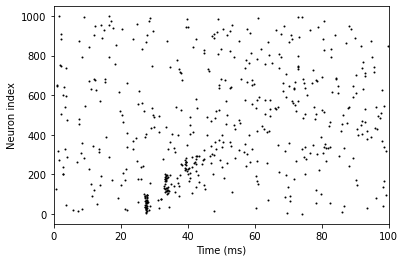

In [9]:
run_network(spike_num=44)